## Ansatz

In [123]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
import numpy as np

### Entropy Ansatz

In [124]:
import scipy.optimize as op

def f(x,S):
    dx = 10**(-15)
    return -np.cos(x/2)**2 * np.log(np.cos(x/2)**2 + dx) - np.sin(x/2)**2 * np.log(np.sin(x/2)**2 + dx) - S

def V(circ,S):
    N = len(circ.qubits)
    j = int(S/np.log(2))
    if j >= N:
        raise NameError("An entropy of "+str(S)+" requires at least "+str(j+1)+" qubits.")
    dS = S - j*np.log(2)
    phi = op.brentq(f,0,np.pi/2, args = (dS))
    for i in range(j):
        circ.h(i)
    circ.ry(phi,j)
    circ.z(j)
    return circ


In [125]:
Q = 4
S = 1.7
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
cir = V(cir,S)
cir.draw()

┌───┐          
q5538_0: ─────┤ H ├──────────
              ├───┤          
q5538_1: ─────┤ H ├──────────
         ┌────┴───┴────┐┌───┐
q5538_2: ┤ Ry(0.62627) ├┤ Z ├
         └─────────────┘└───┘
q5538_3: ────────────────────
                             
c5418: 4/════════════════════

### Hardware Efficient Ansatz

In [126]:
def Ui(cir_i,phi_i):  
    Q = len(phi_i)
    for q in range(0,Q):
        cir_i.ry(phi_i[q],q)
    for q in range(0,Q,4):
        if q+1 < Q:
            cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    for q in range(1,Q,4):
        if q+1 < Q:
            cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    return cir_i

def U(cir,phi_b):
    T = len(phi_b)
    for t in range(T):
        cir = Ui(cir,phi_b[t])
    return cir

def Ui_alt(cir_i,phi_i):  
    Q = len(phi_i)
    for q in range(0,Q):
        cir_i.ry(phi_i[q],q)
    for q in range(0,Q,4):
        if q+1 < Q:
            cir_i.cx(q,q+1)
            cir_i.cx(q+1,q)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
            cir_i.cx(q+2,q+3)
    for q in range(1,Q,4):
        if q+1 < Q:
            cir_i.cx(q,q+1)
            cir_i.cx(q+1,q)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
            cir_i.cx(q+2,q+3)
    return cir_i

def U_alt(cir,phi_b):
    T = len(phi_b)
    for t in range(T):
        cir = Ui_alt(cir,phi_b[t])
    return cir


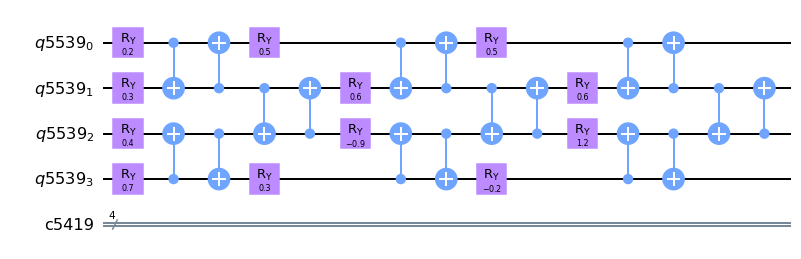

In [127]:
Q = 4
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
tst = U_alt(cir,[[0.2,0.3,0.4,0.7],[0.5,0.6,-0.9,0.3],[0.5,0.6,1.2,-0.2]])

tst.draw(output = 'mpl')

### Combined Ansatz

In [128]:
def A(cir,S,phi):
    cir = V(cir,S)
    cir.barrier()
    cir.measure(cir.qubits,cir.clbits)
    cir.barrier()
    cir = U(cir,phi)
    return cir
    

def cir_A(S,phi):
    Q = len(phi[0])
    qr = QuantumRegister(Q)
    cr = ClassicalRegister(Q)
    cir = QuantumCircuit(qr , cr)
    cir = A(cir,S,phi)
    return cir

def A_alt(cir,S,phi):
    cir = V(cir,S)
    cir.barrier()
    cir.measure(cir.qubits,cir.clbits)
    cir.barrier()
    cir = U_alt(cir,phi)
    return cir
    

def cir_A_alt(S,phi):
    Q = len(phi[0])
    qr = QuantumRegister(Q)
    cr = ClassicalRegister(Q)
    cir = QuantumCircuit(qr , cr)
    cir = A_alt(cir,S,phi)
    return cir

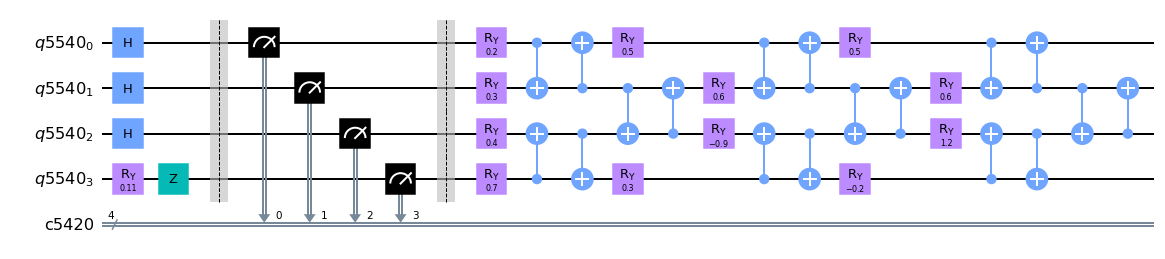

In [129]:
S = 2.1
phi = [[0.2,0.3,0.4,0.7],[0.5,0.6,-0.9,0.3],[0.5,0.6,1.2,-0.2]]


cir = cir_A_alt(S,phi)
cir.draw(output = 'mpl')

### Apply Hamiltonian

### Translate gates and measurments into matrix multiplication 

In [130]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [131]:
from Define_Paulis import I,X,Y,Z,Mdot,bkt

In [132]:
def rho0(N):
    rho = [[0 for i in range(2**N)] for j in range(2**N)]
    rho[0][0] = 1
    return rho

def h(i,N):
    return 1/np.sqrt(2)*(Z(i,N) + X(i,N))

def rx(phi,i,N):
    return np.cos(phi/2)*I(N) - 1j*np.sin(phi/2)*X(i,N)

def ry(phi,i,N):
    return np.cos(phi/2)*I(N) - 1j*np.sin(phi/2)*Y(i,N)

def rz(phi,i,N):
    return np.cos(phi/2)*I(N) - 1j*np.sin(phi/2)*Z(i,N)

def cx(i,j,N):
    return 1/2*( I(N) + Z(i,N) + X(j,N) - Mdot([Z(i,N),X(j,N)]) )
    
def translate(cir):
    N = len(cir.qubits)
    rho = rho0(N)
    for gate in cir:
        if gate[0].name == 'h':
            q = gate[1][0].index
            rho = Mdot([h(q,N),rho,h(q,N)])
        elif gate[0].name == 'ry':
            q = gate[1][0].index
            phi = gate[0].params[0]
            rho = Mdot([ry(phi,q,N),rho,ry(-phi,q,N)])
        elif gate[0].name == 'rx':
            q = gate[1][0].index
            phi = gate[0].params[0]
            rho = Mdot([rx(phi,q,N),rho,rx(-phi,q,N)])
        elif gate[0].name == 'rz':
            q = gate[1][0].index
            phi = gate[0].params[0]
            rho = Mdot([rz(phi,q,N),rho,rz(-phi,q,N)])
        elif gate[0].name == 'cx':
            q1 = gate[1][0].index
            q2 = gate[1][1].index
            rho = Mdot([cx(q1,q2,N),rho,cx(q1,q2,N)])
        elif gate[0].name == 'x':
            q = gate[1][0].index
            rho = Mdot([X(q,N),rho,X(q,N)])
        elif gate[0].name == 'y':
            q = gate[1][0].index
            rho = Mdot([Y(q,N),rho,Y(q,N)])
        elif gate[0].name == 'z':
            q = gate[1][0].index
            rho = Mdot([Z(q,N),rho,Z(q,N)])
        elif gate[0].name == 'barrier':
            q = None
        elif gate[0].name == 'measure':
            q = gate[1][0].index
            rho = 1/4*Mdot([I(N) - Z(q,N),rho,I(N) - Z(q,N)]) + 1/4*Mdot([I(N) + Z(q,N),rho,I(N) + Z(q,N)])
        else:
            print('The gate '+str(gate[0].name)+'was not recognized and was skipped!')
    return rho

# A function to print out the binary number
def bi(num,N):
    bi = bin(num)
    out = ""
    for i in range(2,len(bi)):
        out = out + bi[i]  
    for i in range(len(bi)-2,N):
        out = '0' + out
    return out

def measure_rho(rho):
    L = len(rho)
    N = int(np.log2(L))
    r = {}
    for i in range(L):
        r[bi(i,N)] = rho[i][i]
    return r
    

In [133]:
from qiskit import execute
from qiskit import Aer

sim = Aer.get_backend("qasm_simulator")

cir.measure(cir.qubits,cir.clbits)
r = execute(cir, backend = sim,shots = 100000).result().get_counts()

norm = sum([r[key] for key in list(r.keys())])
[ [key,r[key]/norm] for key in list(r.keys())]

[['1001', 0.01328],
 ['0100', 0.02339],
 ['1100', 0.05717],
 ['0101', 0.01591],
 ['1010', 0.07117],
 ['1011', 0.01939],
 ['1000', 0.06452],
 ['1110', 0.05365],
 ['0010', 0.08664],
 ['0000', 0.1042],
 ['1111', 0.10606],
 ['1101', 0.11265],
 ['0111', 0.03026],
 ['0001', 0.10993],
 ['0011', 0.09384],
 ['0110', 0.03794]]

In [134]:
rho = translate(cir)

measure_rho(rho)

{'0000': (0.10177780763132928+0j),
 '0001': (0.1095647759251699+0j),
 '0010': (0.08678100412363063+0j),
 '0011': (0.09456797241747131+0j),
 '0100': (0.023222192368670607+0j),
 '0101': (0.015435224074829943+0j),
 '0110': (0.038218995876369205+0j),
 '0111': (0.030432027582528557+0j),
 '1000': (0.06612629126107096+0j),
 '1001': (0.013015855633490185+0j),
 '1010': (0.07253823413646705+0j),
 '1011': (0.01942779850888627+0j),
 '1100': (0.05887370873892889+0j),
 '1101': (0.11198414436650966+0j),
 '1110': (0.05246176586353283+0j),
 '1111': (0.10557220149111358+0j)}

## Hamiltonian

In [135]:
import scipy.linalg as ln

H = Z(0,2) + Z(1,2) + 0.3*Mdot([X(0,2),X(1,2)])

e,y = ln.eig(H)
arg = np.argsort(e)
psi = np.conjugate(np.transpose(y))



In [136]:
def H_paulis(m,k):
    h = {'ZI':m,'IZ':m,'XX':k}
    return h

## Pauli Measurments

In [137]:
from qiskit import Aer
from qiskit.visualization import *
from qiskit import quantum_info as qi
import copy

def measure_pauli(p_label,psi0,method = 'simple'):
    
    #Simple method of calculation####
    if method == 'simple':
        rho = translate(psi0)
        Op = qi.Operator.from_label(p_label)
        return np.trace( Mdot([Op,rho]) )
    #################################
        
    #apply rotations#################
    psi = copy.deepcopy(psi0)
    pauli_qs = []
    Z_label = ''
    Q = len(p_label)
    for q,p in enumerate(p_label):
        if p == 'X':
            psi.ry(-np.pi/2,Q-1-q)
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Y':
            psi.rx(np.pi/2,Q-1-q)
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Z':
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'I':
            pauli_qs.append(0)
            Z_label += 'I'
    ################################
    
    #Using matrix multiplication####
    if method == 'matrix':
        # add results
        rho = translate(psi)
        r = measure_rho(rho)
        z_measure = 0
        for key in list(r.keys()):
            n = 0
            for q in range(len(key)):
                if key[q] == '1' and pauli_qs[q] == 1:
                    n += 1
            z_measure += (-1)**n * r[key] 
        return z_measure
    #################################
    
    #Using the qasm simulator########
    if method == "simulator":
        sim = Aer.get_backend("qasm_simulator")
        psi.measure(psi.qubits,psi.clbits)
        r = execute(psi, backend = sim,shots = 10000).result().get_counts()
        z_measure = 0
        total = 0
        for key in list(r.keys()):
            n = 0
            for q in range(len(key)):
                if key[q] == '1' and pauli_qs[q] == 1:
                    n += 1
            z_measure += (-1)**n * r[key] 
            total += r[key]
        return z_measure/total
    ###################################
    
    raise NameError(method + ' is not a recognized method')
    return method + ' is not a recognized method'
  

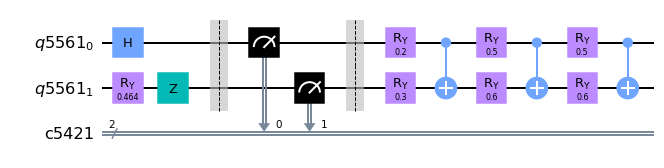

In [138]:
Q = 2
S = 0.9
phi = [[0.2,0.3],[0.5,0.6],[0.5,0.6]]
cir = cir_A(S,phi)
cir.draw(output = 'mpl')

In [139]:
measure_pauli('ZI',cir,method = 'simulator')

-0.3132

In [140]:
measure_pauli('ZI',cir,method = 'matrix')

(-0.31785621662709335+0j)

In [141]:
measure_pauli('ZI',cir,method = 'simple')

(-0.3178562166270934+0j)

In [142]:
ezi = measure_pauli('IZ',cir,method = 'simple')
eiz = measure_pauli('ZI',cir,method = 'simple')
exx = measure_pauli('XX',cir,method = 'simple')

ezi + eiz + 0.3*exx

(-0.367845972910567+0j)

In [143]:
def measure_E(H_paulis,cir,method = 'simple'):
    paulis = list(H_paulis.keys())
    e = 0
    for p in paulis:
        ep = H_paulis[p] * measure_pauli(p,cir,method)
        e += ep
    return e

In [144]:
measure_E(H_paulis(1,0.3), cir, method = 'matrix')

(-0.3678459729105669+0j)

In [145]:
rho = translate(cir)
np.trace( Mdot([H,rho]) )

(-0.367845972910567+0j)

## Optimize

I have defined the free energy as $$ E_f = <H> + TS $$ but it is supposed to be $$ E_f = <H> - TS $$.  However, this means entropy should be as large as possible so entropy is always $S = 0$ regardless of $T$.

The issue is that I have entropy defined backwards.  Entropy should increase with spreading weight not decrease.  
$$ S = - \text{Tr} \rho \ln \rho = \text{Tr} \rho \ln \frac{1}{\rho}$$

I have 
$$ S = - \text{Tr} \rho \ln \frac{1}{\rho}$$
by mistake

In [146]:
def enforce_bounds(S,Smin,Smax):
    if S < Smin:
        S = Smin
    if S > Smax:
        S = Smax
    return S

In [147]:
def SPSA(T,S0,phi0,k_max,hpauli,method = 'simple'):
    beta = 0.201
    A = 10
    a = 0.05
    gamma = 0.101
    c = 0.4
    np.random.seed(10)
    
    #Initalization
    k = 0
    Nt = len(phi0)
    N = len(phi0[0])
    max_S = 0.999*N*np.log(2)
    phi_k = np.array(phi0)
    S_k = S0
    E_l = []
    k_l = []
    
    #Begin Iterations
    for k in range(k_max):
        #Update c and a
        a_k = a/((A + k + 1)**beta)
        c_k = c/((k + 1)**gamma)

        #Find Delta
        Delta_k = np.array(phi_k)
        for t in range(Nt):
            for q in range(N):
                Delta_k[t][q] = 1 - 2*np.random.binomial(size=None, n=1, p= 0.5)
        phi_k_A = phi_k + c_k*Delta_k
        phi_k_B = phi_k - c_k*Delta_k
        
        #Find Delta S
        Delta_Sk =  1 - 2*np.random.binomial(size=None, n=1, p= 0.5)
        S_k_A = S_k + c_k*Delta_Sk
        S_k_B = S_k - c_k*Delta_Sk
        S_k_A = enforce_bounds(S_k_A, 0, max_S)
        S_k_B = enforce_bounds(S_k_B, 0, max_S)
        
        #Find cir 
        cirA = cir_A(S_k_A,phi_k_A)
        cirB = cir_A(S_k_B,phi_k_B)
            
        #Find energy expectation value
        e_A = measure_E(hpauli, cirA, method = method)
        e_B = measure_E(hpauli, cirB, method = method)
        
        
        #Find Free Energy    
        E_A = e_A - S_k_A*T
        E_B = e_B - S_k_B*T
        
        #Calculate gradiant
        g = np.real((E_A-E_B)/(2*c_k)) 
        
        #Update phi
        g_k = g * Delta_k
        phi_k = phi_k - a_k * g_k
        
        #Update S
        g_Sk = g * Delta_Sk
        S_k = S_k - a_k * g_Sk
        S_k = enforce_bounds(S_k, 0, max_S)
        
        #Find new cir
        cir_n = cir_A(S_k,phi_k)
        
        #Find new energy expectation value
        e_n = measure_E(hpauli, cir_n, method = method)
        
        #Find new Free Energy
        E = e_n - S_k*T
        
        print(k,S_k,E)
        E_l.append(E)
        k_l.append(k)

    return E_l,k_l,S_k,phi_k

## Get results

In [148]:
import matplotlib.pyplot as plt

In [149]:
hpauli = H_paulis(1,0.3)

In [150]:
S0 = (0.0)*2*np.log(2)
phi0 = [[0.3,0.2],[0.5,0.1],[0.3,0.7],[1.2,0.9]]
#phi0 = [[0.3,0.2],[-0.5,0.1],[0.3,0.7],[0.1,0.8],[0.3,0.2],[0.3,0.3],[-0.2,0.1]]

T = 2.0
kmax = 300
El,kl,Sf,phif = SPSA(T, S0, phi0, kmax, hpauli)

0 0.059332059068005254 (-0.198284613671054+0j)
1 0.04231954136423313 (-0.2015183443685975+0j)
2 0.1157732926591569 (-0.4637740288766082+0j)
3 0.11352503825041414 (-0.4633662925199228+0j)
4 0.21265647406180993 (-0.9176686922069537+0j)
5 0.25644355869716584 (-1.0106162809074402+0j)
6 0.3488701706993461 (-1.3258521824623237+0j)
7 0.3761534260367049 (-1.3575806331386213+0j)
8 0.43321661475387463 (-1.4710280420547457+0j)
9 0.4337588716266851 (-1.4708040294217595+0j)
10 0.48616455342026016 (-1.5865859778860645+0j)
11 0.5066283991676163 (-1.5862401977421676+0j)
12 0.5811480664245358 (-1.8098884912847706+0j)
13 0.6155246132940233 (-1.8459121031626151+0j)
14 0.6786345136171704 (-1.9547460568657922+0j)
15 0.7576007232735428 (-2.091093436657792+0j)
16 0.7909494239091839 (-2.1187175796421456+0j)
17 0.8138666623812975 (-2.1530537192508064+0j)
18 0.8455989318575536 (-2.2204542730566343+0j)
19 0.9055098521706336 (-2.362192362101225+0j)
20 0.9455362033015234 (-2.43354440419089+0j)
21 0.989632114499292

182 1.352079843502956 (-2.9543518578284003+0j)
183 1.3497153758530123 (-2.9580297368644306+0j)
184 1.3512668996718409 (-2.9558035810988037+0j)
185 1.3496448902738811 (-2.958395556262458+0j)
186 1.3492084619983618 (-2.959034793497424+0j)
187 1.3483789723879933 (-2.9602232882380326+0j)
188 1.3494484641998623 (-2.9587381901089262+0j)
189 1.3513043377248946 (-2.955900256483772+0j)
190 1.3525536302534809 (-2.953960405970017+0j)
191 1.3504341548933734 (-2.9573600928834685+0j)
192 1.351939125107329 (-2.955186468205678+0j)
193 1.353944252300614 (-2.951869748880664+0j)
194 1.356864510990729 (-2.9467381244483697+0j)
195 1.3596742014153702 (-2.9413652673133273+0j)
196 1.358745975897789 (-2.943296899979675+0j)
197 1.3565186085983807 (-2.9478104289986735+0j)
198 1.3519689180067096 (-2.9561598689368376+0j)
199 1.3496959138487152 (-2.959769814258248+0j)
200 1.3467175391555057 (-2.96421907835178+0j)
201 1.3517755474281492 (-2.9569658965806047+0j)
202 1.353228115551913 (-2.9544390587701663+0j)
203 1.35

/opt/miniconda3/envs/qiskit_3.5/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(-3.5, 0.0)

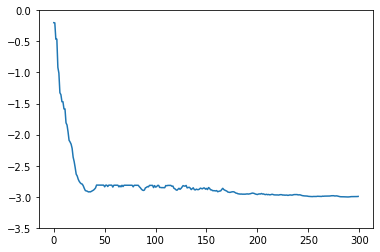

In [151]:
plt.plot(kl,El)
plt.ylim(-3.5,0.0)

### Check

In [152]:
H = Z(0,2) + Z(1,2) + 0.3*Mdot([X(0,2),X(1,2)])

e,y = ln.eig(H)
arg = np.argsort(e)
psi = np.conjugate(np.transpose(y))
    


def ketbra(psia,psib):
    out = [[0 for i in range(len(psia))] for j in range(len(psib))]
    for i in range(len(psia)):
        for j in range(len(psib)):
            out[i][j] = psia[i]*np.conjugate( psib[j] )
    return np.array(out)
            
def S(rho):
    e,y = ln.eig(rho)
    s = -sum([np.round( (e[n]+10**-28)*np.log(e[n]+10**(-28)) , 8) for n in range(len(e))])
    return s

def FreeE(T,H,rho):
    #print('H: ',np.trace(Mdot([H,rho])))
    #print('S: ', + T*S(rho))
    return np.trace(Mdot([H,rho])) - T*S(rho)
    

def rho(a,b,c,d):
    rho0 = a*ketbra(psi[arg[0]],psi[arg[0]]) + b*ketbra(psi[arg[1]],psi[arg[1]]) + c*ketbra(psi[arg[2]],psi[arg[2]]) + d*ketbra(psi[arg[3]],psi[arg[3]])
    rho0 = rho0/np.trace(rho0)
    return rho0

In [165]:
S(rhop)
rhop
a*ketbra(psi[arg[0]],psi[arg[0]])

array([[ 0.01520623+0.j,  0.        +0.j,  0.        +0.j,
        -0.2038838 +0.j],
       [ 0.        +0.j,  0.        +0.j,  0.        +0.j,
        -0.        +0.j],
       [ 0.        +0.j,  0.        +0.j,  0.        +0.j,
        -0.        +0.j],
       [-0.2038838 +0.j, -0.        +0.j, -0.        +0.j,
         2.73365691+0.j]])

(-3.5, 0.0)

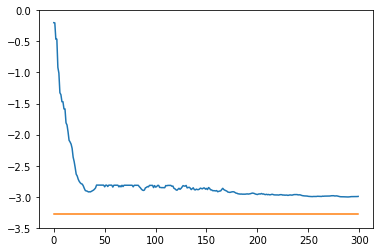

In [153]:
a = np.exp( -e[arg[0]]/T )
b = np.exp( -e[arg[1]]/T ) 
c = np.exp( -e[arg[2]]/T )
d = np.exp( -e[arg[3]]/T )
rhop = rho(a,b,c,d)


Ep = FreeE(T,H,rhop)
Epl = [Ep for k in kl]

plt.plot(kl,El)
plt.plot(kl,Epl)
plt.ylim(-3.5,0.0)

In [154]:
import scipy.optimize as op

def Hd(i,N):
    return 1/np.sqrt(2)*(Z(i,N) + X(i,N))

def RH(theta,i,N):
    return Mdot([Z(i,N),np.cos(theta/2)*I(N) - 1j*np.sin(theta/2)*Y(i,N)])


def f(x,S):
    dx = 10**(-15)
    return -np.cos(x/2)**2 * np.log(np.cos(x/2)**2 + dx) - np.sin(x/2)**2 * np.log(np.sin(x/2)**2 + dx) - S

def VM(S,N):
    j = int(S/np.log(2))
    if j >= N:
        raise NameError("An entropy of "+str(S)+" requires at least "+str(j+1)+" qubits.")
    dS = S - j*np.log(2)
    phi = op.brentq(f,0,np.pi/2, args = (dS))
    vout = I(N)
    for i in range(j):
        vout = Mdot([Hd(i,N),vout])
    vout = Mdot([RH(phi,j,N),vout])
    return vout

def M(il,N):
    Ml = [I(N)]
    for i in il:  
        M2 = []
        for M in Ml:
            Ma = 1/2*Mdot([M,(I(N)+Z(i,N))])
            Mb = 1/2*Mdot([M,(I(N)-Z(i,N))])
            M2.append(Ma)
            M2.append(Mb)
        Ml = M2
    return Ml

def Meas(rho,il):
    N = int(np.log2(len(rho)))
    ml = M(il,N)
    rho_new = 0*rho
    for m in ml:
        rho_new = rho_new + Mdot([m,rho,m])
    return rho_new

def Ry(theta,i,N):
    return np.cos(theta/2)*I(N) - 1j*np.sin(theta/2)*Y(i,N)

def Cx(i,j,N):
    return 1/2*( I(N) + Z(i,N) + X(j,N) - Mdot([Z(i,N),X(j,N)]) )


def UM(Phi):
    T = len(Phi)
    N = len(Phi[0])
    uout = I(N)
    gates = []
    for t in range(T):
        for i in range(N):
            phi = Phi[t][i]
            uout = Mdot([Ry(phi,i,N),uout])
            gates.append(['ry',phi,i])
        for i in range(0,N,2):
            uout = Mdot([Cx(i,i+1,N),uout])
            gates.append(['cx',i,i+1])
        for i in range(1,N,2):
            uout = Mdot([Cx(i,i+1,N),uout])
            gates.append(['cx',i,i+1])
    #print(gates)
    return uout


def rho0M(a,b,c,d):
    rho = [[0 for i in range(4)] for j in range(4)]
    rho[arg[0]][arg[0]] = a
    rho[arg[1]][arg[1]] = b
    rho[arg[2]][arg[2]] = c
    rho[arg[3]][arg[3]] = d
    rho = rho/np.trace(rho)
    return rho

def rhof(Sin,Phi):
    N = len(Phi[0])
    rhoi = rho0M(0,0,0,1)
    rhov = Mdot([VM(Sin,N),rhoi,np.conjugate(np.transpose(VM(Sin,N)))])
    rho00 = Meas(rhov,[0,1,2,3])
    rhop = Mdot([UM(Phi),rho00,np.conjugate(np.transpose(UM(Phi)))])
    return rhop


S0 = (0.3)*2*np.log(2)
phi0 = [[0.3,0.2],[0.5,0.1],[0.3,0.7],[1.2,0.9]]
#phi0 = [[0.33,0.55]]
print( rhof(S0,phi0) )

[[ 0.26194164+0.j  0.31851665+0.j  0.09174128+0.j  0.06718781+0.j]
 [ 0.31851665+0.j  0.52438159+0.j  0.25942246+0.j  0.05605093+0.j]
 [ 0.09174128+0.j  0.25942246+0.j  0.1916439 +0.j -0.00413687+0.j]
 [ 0.06718781+0.j  0.05605093+0.j -0.00413687+0.j  0.02203287+0.j]]


In [155]:
Q = 2
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
cir = V(cir,S0)
cir.measure(cir.qubits,cir.clbits)
cir = U_alt(cir,phi0)
print(translate(cir))

[[ 0.26194164+0.j  0.31851665+0.j  0.09174128+0.j  0.06718781+0.j]
 [ 0.31851665+0.j  0.52438159+0.j  0.25942246+0.j  0.05605093+0.j]
 [ 0.09174128+0.j  0.25942246+0.j  0.1916439 +0.j -0.00413687+0.j]
 [ 0.06718781+0.j  0.05605093+0.j -0.00413687+0.j  0.02203287+0.j]]


In [87]:
def S(rho):
    e,y = ln.eig(rho)
    s = -sum([np.round( (e[n]+10**-28)*np.log(e[n]+10**(-28)) , 8) for n in range(len(e))])
    return s

def FreeE(T,H,rho):
    #print('H: ',np.trace(Mdot([H,rho])))
    #print('S: ', + T*S(rho))
    return np.trace(Mdot([H,rho])) - T*S(rho)
    


def SPSA(T,S0,phi0,k_max):
    beta = 0.201
    A = 10
    a = 0.05
    gamma = 0.101
    c = 0.4
    np.random.seed(10)
    
    #Initalization
    k = 0
    Nt = len(phi0)
    N = len(phi0[0])
    max_S = 0.999*N*np.log(2)
    phi_k = np.array(phi0)
    S_k = S0
    E_l = []
    k_l = []
    
    #Begin Iterations
    for k in range(k_max):
        #Update c and a
        a_k = a/((A + k + 1)**beta)
        c_k = c/((k + 1)**gamma)

        #Find Delta
        Delta_k = np.array(phi_k)
        for t in range(Nt):
            for q in range(N):
                Delta_k[t][q] = 1 - 2*np.random.binomial(size=None, n=1, p= 0.5)
        phi_k_A = phi_k + c_k*Delta_k
        phi_k_B = phi_k - c_k*Delta_k
        
        #Find Delta S
        Delta_Sk =  1 - 2*np.random.binomial(size=None, n=1, p= 0.5)
        S_k_A = S_k + c_k*Delta_Sk
        S_k_B = S_k - c_k*Delta_Sk
        S_k_A = enforce_bounds(S_k_A, 0, max_S)
        S_k_B = enforce_bounds(S_k_B, 0, max_S)
        
        #Find rho 
        rho_A = rhof(S_k_A,phi_k_A)
        rho_B = rhof(S_k_B,phi_k_B)
            
        #Find Free Energy    
        E_A = FreeE(T,H,rho_A)
        E_B = FreeE(T,H,rho_B)
        
        #Calculate gradiant
        g = np.real((E_A-E_B)/(2*c_k)) 
        
        #Update phi
        g_k = g * Delta_k
        phi_k = phi_k - a_k * g_k
        
        #Update alpha
        g_Sk = g * Delta_Sk
        S_k = S_k - a_k * g_Sk
        S_k = enforce_bounds(S_k, 0, max_S)
        
        #Find new rho
        rho = rhof(S_k,phi_k)
        
        #Find new Free Energy
        E = FreeE(T,H,rho)
        
        print(k,S_k,E)
        E_l.append(E)
        k_l.append(k)

    return E_l,k_l,S_k,phi_k

In [88]:
S0 = (0.0)*2*np.log(2)
phi0 = [[0.3,0.2],[0.5,0.1],[0.3,0.7],[1.2,0.9]]
#phi0 = [[0.3,0.2],[-0.5,0.1],[0.3,0.7],[0.1,0.8],[0.3,0.2],[0.3,0.3],[-0.2,0.1]]

T = 2.0
El,kl,Sf,phif = SPSA(T, S0, phi0, 300)

0 0.040641969955196755 (0.5680233359377105+0j)
1 0.0386193853240869 (0.5687703052787614+0j)
2 0.07359687990651145 (0.49134273313900717+0j)
3 0.0714690120265681 (0.4907534951497312+0j)
4 0.07627869754269555 (0.4866509452319266+0j)
5 0.13868657236640317 (0.29423369504962193+0j)
6 0.18128554653723636 (0.16796191772591945+0j)
7 0.2571824141513479 (-0.12105254718900621+0j)
8 0.3182845703921815 (-0.280076065984681+0j)
9 0.38009309404959457 (-0.4414913877800981+0j)
10 0.4831499781734632 (-0.8660368269212905+0j)
11 0.5208217747574171 (-0.9258149662289963+0j)
12 0.538173851854324 (-0.9447443028924398+0j)
13 0.5948501698167356 (-1.0806317196925561+0j)
14 0.6356665298229122 (-1.1231949204478335+0j)
15 0.7342734138321979 (-1.4291562363473238+0j)
16 0.7961575875164619 (-1.6047885497843606+0j)
17 0.8760117287735895 (-1.932381403231819+0j)
18 0.9086669188515526 (-1.943401778426221+0j)
19 0.9558612020349915 (-2.033745435100376+0j)
20 0.9780884772557781 (-2.041141658810899+0j)
21 1.0396498028236967 (-2

176 1.3401640804284918 (-2.9940660545489486+0j)
177 1.3379422790618714 (-2.997119767890942+0j)
178 1.3333384161788462 (-3.0027627643349515+0j)
179 1.3271513456308075 (-3.010150851483131+0j)
180 1.3240643086798907 (-3.0127846886494263+0j)
181 1.324086584162204 (-3.0127647007903424+0j)
182 1.3189909643590243 (-3.017295272469485+0j)
183 1.3184912710351082 (-3.0177768792657287+0j)
184 1.3212133778429975 (-3.016346834643007+0j)
185 1.3248958285383468 (-3.014056198865139+0j)
186 1.3297486163136882 (-3.0099473285782725+0j)
187 1.3244720869869746 (-3.0154183261823464+0j)
188 1.3224690987205812 (-3.0172252897536116+0j)
189 1.31924093691211 (-3.019905001443318+0j)
190 1.313403522566098 (-3.0254208519206163+0j)
191 1.3128552204265667 (-3.025844756842399+0j)
192 1.3125864703454921 (-3.02608137597751+0j)
193 1.3085984394638595 (-3.0291353467368833+0j)
194 1.3138838828471606 (-3.0279745956776+0j)
195 1.3112387585724168 (-3.0296384856418896+0j)
196 1.3155971998314449 (-3.02708616264477+0j)
197 1.3238

(-3.5, 0.0)

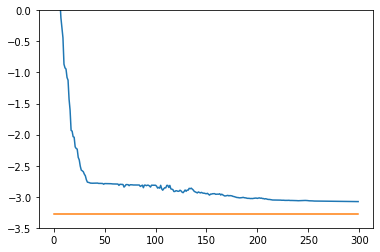

In [89]:
a = np.exp( -e[arg[0]]/T )
b = np.exp( -e[arg[1]]/T ) 
c = np.exp( -e[arg[2]]/T )
d = np.exp( -e[arg[3]]/T )
rhop = rho(a,b,c,d)


Ep = FreeE(T,H,rhop)
Epl = [Ep for k in kl]

plt.plot(kl,El)
plt.plot(kl,Epl)
plt.ylim(-3.5,0.0)

In [90]:
def SPSA(T,S0,phi0,k_max,hpauli,method = 'simple'):
    beta = 0.201
    A = 10
    a = 0.05
    gamma = 0.101
    c = 0.4
    
    beta_tst = 0.201
    A_tst = 10
    a_tst = 0.05
    gamma_tst = 0.101
    c_tst = 0.4
    np.random.seed(10)
    
    #Initalization
    k = 0
    Nt = len(phi0)
    N = len(phi0[0])
    max_S = 0.999*N*np.log(2)
    phi_k = np.array(phi0)
    phi_k_tst = np.array(phi0)
    S_k = S0
    S_k_tst = S0
    E_l = []
    k_l = []
    
    #Begin Iterations
    for k in range(k_max):
        #Update c and a
        a_k = a/((A + k + 1)**beta)
        c_k = c/((k + 1)**gamma)
        
        a_k_tst = a_tst/((A_tst + k + 1)**beta_tst)
        c_k_tst = c_tst/((k + 1)**gamma_tst)

        #Find Delta
        Delta_k = np.array(phi_k)
        for t in range(Nt):
            for q in range(N):
                Delta_k[t][q] = 1 - 2*np.random.binomial(size=None, n=1, p= 0.5)
        phi_k_A = phi_k + c_k*Delta_k
        phi_k_B = phi_k - c_k*Delta_k
        phi_k_A_tst = phi_k_tst + c_k_tst*Delta_k
        phi_k_B_tst = phi_k_tst - c_k_tst*Delta_k
        
        #Find Delta S
        Delta_Sk =  1 - 2*np.random.binomial(size=None, n=1, p= 0.5)
        S_k_A = S_k + c_k*Delta_Sk
        S_k_B = S_k - c_k*Delta_Sk
        S_k_A = enforce_bounds(S_k_A, 0, max_S)
        S_k_B = enforce_bounds(S_k_B, 0, max_S)
        S_k_A_tst = S_k_tst + c_k_tst*Delta_Sk
        S_k_B_tst = S_k_tst - c_k_tst*Delta_Sk
        S_k_A_tst = enforce_bounds(S_k_A_tst, 0, max_S)
        S_k_B_tst = enforce_bounds(S_k_B_tst, 0, max_S)
        
        
        #Find cir 
        cirA = cir_A_alt(S_k_A,phi_k_A)
        cirB = cir_A_alt(S_k_B,phi_k_B)
            
        #Find energy expectation value
        e_A = measure_E(hpauli, cirA, method = method)
        e_B = measure_E(hpauli, cirB, method = method)
        
        
        #Find Free Energy    
        E_A = e_A - S_k_A*T
        E_B = e_B - S_k_B*T
        
        #Find rho 
        rho_A_tst = rhof(S_k_A_tst,phi_k_A_tst)
        rho_B_tst = rhof(S_k_B_tst,phi_k_B_tst)
            
        #Find Free Energy    
        E_A_tst = FreeE(T,H,rho_A_tst)
        E_B_tst = FreeE(T,H,rho_B_tst)
        
        print('!', E_B,E_B_tst)
        
        #Calculate gradiant
        g = np.real((E_A-E_B)/(2*c_k)) 
        g_tst = np.real((E_A_tst-E_B_tst)/(2*c_k_tst)) 
        
        #Update phi
        g_k = g * Delta_k
        phi_k = phi_k - a_k * g_k
        g_k_tst = g_tst * Delta_k
        phi_k_tst = phi_k_tst - a_k_tst * g_k_tst
        
        #Update S
        g_Sk = g * Delta_Sk
        S_k = S_k - a_k * g_Sk
        S_k = enforce_bounds(S_k, 0, max_S)
        g_Sk_tst = g_tst * Delta_Sk
        S_k_tst = S_k_tst - a_k_tst * g_Sk_tst
        S_k_tst = enforce_bounds(S_k_tst, 0, max_S)
        
        #Find new cir
        cir_n = cir_A_alt(S_k,phi_k)
        
        #Find new energy expectation value
        e_n = measure_E(hpauli, cir_n, method = method)
        
        #Find new Free Energy
        E = e_n - S_k*T
        
        #Find new rho
        rho = rhof(S_k_tst,phi_k_tst)
        
        #Find new Free Energy
        E_tst = FreeE(T,H,rho)
        
        #print(k,S_k,E,S_k_tst,E_tst)
        E_l.append(E)
        k_l.append(k)

    return E_l,k_l,S_k,phi_k

In [91]:
S0 = -(0.0)*2*np.log(2)
phi0 = [[0.3,0.2],[0.5,0.1],[0.3,0.7],[1.2,0.9]]
#phi0 = [[0.3,0.2],[-0.5,0.1],[0.3,0.7],[0.1,0.8],[0.3,0.2],[0.3,0.3],[-0.2,0.1]]

T = 2.0
k_max = 300
El,kl,Sf,phif = SPSA(T,S0,phi0,k_max,hpauli)

! (0.5313641998110907+0j) (0.5313641998110908+0j)
! (-0.03256152345070856+0j) (-0.03256152345070866+0j)
! (-0.47674216982339235+0j) (-0.476742167665991+0j)
! (0.2612229372448667+0j) (0.2612229372587324+0j)
! (-0.06818418430300963+0j) (-0.06818418351401331+0j)
! (1.0186348701029024+0j) (1.0186348698924355+0j)
! (-0.5688564110184229+0j) (-0.568856410897718+0j)
! (0.8091196388550075+0j) (0.8091196380146949+0j)
! (-1.0229093982147797+0j) (-1.0229093950317192+0j)
! (-1.4111856295552876+0j) (-1.4111856451566986+0j)
! (0.7582765227269582+0j) (0.7582765257004125+0j)
! (-0.6120977951784331+0j) (-0.6120978042187804+0j)
! (-1.173527430606723+0j) (-1.1735274517748469+0j)
! (-1.6179665348042953+0j) (-1.617966562825565+0j)
! (-1.6259213245367043+0j) (-1.6259213167342383+0j)
! (-2.0528706751816435+0j) (-2.0528706877889484+0j)
! (-2.2722119026509504+0j) (-2.2722119057792454+0j)
! (-0.8542326020038367+0j) (-0.8542326091207357+0j)
! (-2.1156045130298122+0j) (-2.1156045239771037+0j)
! (-2.370043077176297

! (-2.815768049807624+0j) (-2.8157680360841786+0j)
! (-2.828143806074453+0j) (-2.8281437998661505+0j)
! (-2.8254156814322826+0j) (-2.8254156677760434+0j)
! (-2.803912671109491+0j) (-2.803912657665136+0j)
! (-2.6221719033695914+0j) (-2.622171904678297+0j)
! (-2.910957214784622+0j) (-2.9109571748466694+0j)
! (-2.817557780036386+0j) (-2.8175577665620692+0j)
! (-2.948699713683342+0j) (-2.9486997133394244+0j)
! (-2.818324874882938+0j) (-2.8183248613978873+0j)
! (-2.7321446171952974+0j) (-2.732144578927162+0j)
! (-2.8065328644032617+0j) (-2.8065328507979928+0j)
! (-2.947614697266538+0j) (-2.947614685524891+0j)
! (-2.827155176340426+0j) (-2.8271551626295737+0j)
! (-2.814711668635282+0j) (-2.8147116551212785+0j)
! (-2.8235541328810934+0j) (-2.823554119174964+0j)
! (-2.821488466575928+0j) (-2.8214884527288455+0j)
! (-2.87297231981867+0j) (-2.8729722912307682+0j)
! (-2.8217726203237565+0j) (-2.821772606617203+0j)
! (-2.8160253790960708+0j) (-2.8160253651769573+0j)
! (-2.9101586843200264+0j) (-2.